
**A Tensorflow Implementation of 'Text Understanding From Scratch', a Character-Level Deep ConvNet for Sentence Classification**



This is a tensorflow implementation of 'Text Understanding From Scratch' by Xiang Zhang and Yann LeCun. The paper can be found here: https://arxiv.org/abs/1502.01710


The paper describes a Deep Character-Level CNN which has been implemented in tensorflow in this notebook. There are a few differences
1. 43 characters are used instead of the range of 69 characters in the original.
2. The length sequence was taken as upto the 75th percentile of the length of all the sentences. This number is 584 characters, after stripping the unwanted characters as above
3. Batch Normalization was applied in all layers except the character quantization layer and final layer


** Step 1: Initialize all the dependencies**

In [3]:
import os, random , math, shutil, glob, uuid
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
np.set_printoptions(threshold=np.nan)

'''
# For removal of stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from stop_words import get_stop_words
'''


** Step 2: Initialize all the global variables including character dictionary size**

In [2]:
# Location of the dataset and disk cache files
home_dir = ''

# Files for train dataset disk cache
one_hot_train_dir = home_dir + 'train/'

# Files for validation dataset disk cache
one_hot_valid_dir = home_dir + 'valid/

# Files for test dataset disk cache
one_hot_test_dir = home_dir + 'test/'

# The training file
train_file = home_dir + 'train_sample.csv'

# Testing file
test_file = home_dir + 'test_sample.csv'


# Stores all the checkpoints
checkpoint_dir = ''


# The original dictionary from the paper
'''
one_hot_column_label = {'a':68,'b':67,'c':66,'d':65,'e':64,'f':63,'g':62,'h':61,'i':60,'j':59,'k':58,'l':57,'m':56,'n':55,'o':54,
                        'p':53,'q':52,'r':51,'s':50,'t':49,'u':48,'v':47,'w':46,'x':45,'y':44,'z':43,'0':42,'1':41,'2':40,'3':39,'4':38,'5':37,'6':36,'7':35,
                        '8':34,'9':33,'-':32,',':31,';':30,'.':29,'!':28,'?':27,':':26,'"':25,'\'':24,'/':23,'\\':22,'|':21,'_':20,
                        '@':19,'#':18,'$':17,'%':16,'^':15,'&':14,'*':13,'~':12,'`':11,'+':10,'-':9,'=':8,'<':7,'>':6,'(':5,')':4,'[':3,
                        ']':2,'{':1,'}':0}
'''


# Index denotes the column placement in the one-hot vector matrix
# This is used to create the one-hot character vector of sentence inputs
one_hot_column_label = {'a':42,'b':41,'c':40,'d':39,'e':38,'f':37,'g':36,'h':35,'i':34,'j':33,'k':32,'l':31,'m':30,'n':29,'o':28,
                        'p':27,'q':26,'r':25,'s':24,'t':23,'u':22,'v':21,'w':20,'x':19,'y':18,'z':17,'0':16,'1':15,'2':14,'3':13,'4':12,'5':11,'6':10,'7':9,
                        '8':8,'9':7,'-':6,'#':5,'.':4,'!':3,'?':2,':':1,';':0}


# Dimension attribute for one-hot character matrix
num_chars_dict = 43

# Number of labels to classify
num_labels = 5

# Tensorboard directories
train_tensorboard_dir = home_dir + 'train/tensorboard/'
valid_tensorboard_dir = home_dir + 'valid/tensorboard/'


# A log directory where confusion matrix, loss value, accuracy value will be written to
log_dir = ''



** Step 3: Pre-processing of sentences**
<br />
1. Remove unwanted characters <br/>
2. Get sentence Length parameter for the Network (cutoff_len) <br/>
3. Get the train-dev dataset split <br/>
4. Verify that stratified sampling was done correctly in the train-dev split <br/>
5. Optional - remove stopwords
<br/>
<br/>
There are ~624,000 examples in the training dataset, and 20,000 in the dev dataset


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The longest sentence is of length:1003
The shortest sentence is of length:9
The average length is:428.683941052217
The 75th percentile is:584.0
The 90th percentile is:778.0
Verify Stratified Sampling
584
The cutoff length and counts
584
623999
26000


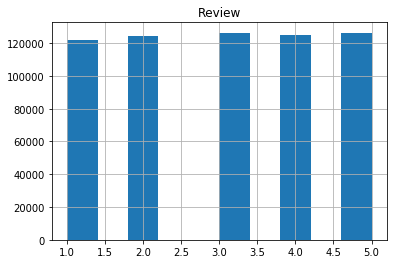

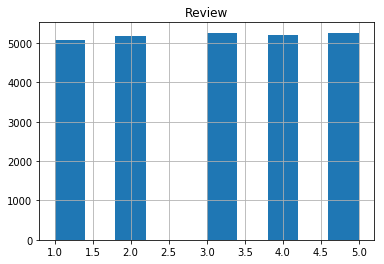

In [3]:

def strip_characters(sent):
    
    """
    Function strips the unwanted characters from the sentence
    Add extra functionality here (e.g, removal of stopwords)
    """
    
    #sent = sent.replace('-','')
    sent = sent.replace(',','')
    #sent = sent.replace(';','')
    #sent = sent.replace('.','')
    #sent = sent.replace(':','')
    sent = sent.replace('"','')
    
    sent = sent.replace('/','')
    sent = sent.replace('\\','')
    sent = sent.replace('|','')
    sent = sent.replace('_','')
    sent = sent.replace('@','')
    #sent = sent.replace('#','')
    sent = sent.replace('$','')
    sent = sent.replace('^','')                        
    sent = sent.replace('&','')                        
    sent = sent.replace('*','')                        
    sent = sent.replace('~','')                            
    sent = sent.replace('`','')    
    sent = sent.replace('+','')                        
    sent = sent.replace('-','')    
    sent = sent.replace('=','')
    sent = sent.replace('<','')
    sent = sent.replace('>','')                        
    sent = sent.replace('(','')                        
    sent = sent.replace(')','')                        
    sent = sent.replace('[','')                        
    sent = sent.replace(']','')                        
    sent = sent.replace('{','')                        
    sent = sent.replace('}','')        
    
    '''
    # remove the stop words
    stop_words = list(get_stop_words('en'))
    nltk_words = list(stopwords.words('english'))
    stop_words.extend(nltk_words)
    sent_words = sent.split(' ')
    sent_stopped_words = [w for w in sent_words if not w in stop_words]
    stopped_sent = ' '.join(sent_stopped_words)
    '''
    
    return sent

                        
def main():                        

    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)

    # We get the max_len for padding and for the convolution filter definition in the model
    max_len = 0
    total_len = 0
    min_len = 999
    ls_len = []
    
    # Used to store the processed reviews
    stripped_file_train =  home_dir + 'file_strip_train.csv'   
    stripped_file_test = home_dir + 'file_strip_test.csv'

    with open(stripped_file_train,'w') as strip:   
    
        strip.write('Review' + ',' + 'Description' + '\n')

        for index,row in train_data.iterrows():
    
            sent_row = strip_characters(row[2])
            strip.write(str(row[0]) + ','  + sent_row + '\n')    
        
        
    with open(stripped_file_test,'w') as strip:
     
        strip.write('Review' + ',' + 'Description' + '\n')
    
        for index,row in test_data.iterrows():
        
            sent_row = strip_characters(row[2])
            strip.write(str(row[0]) + ','  + sent_row + '\n')    

        

    strip_train_data = pd.read_csv(stripped_file_train)
    X_test = pd.read_csv(stripped_file_test)
        
    label_data = strip_train_data.loc[:,'Review']
    all_data = strip_train_data
    all_data = all_data.append(X_test,ignore_index=True)

    for index, row in all_data.iterrows():
        total_len += len(row[1])
        ls_len.append(len(row[1]))
        if (max_len < len(row[1])):
            max_len = len(row[1])
        if (min_len > len(row[1])):
            min_len = len(row[1])
            
    np_len = np.asarray(ls_len)
    
    # Statistics on the reviews
    print ('The longest sentence is of length:' + str(max_len))
    print ('The shortest sentence is of length:' + str(min_len))
    print ('The average length is:' + str(total_len/strip_train_data.shape[0]))
    print ('The 75th percentile is:' + str(np.percentile(np_len,75)))
    print ('The 90th percentile is:' + str(np.percentile(np_len,90)))



    # Train and test split (stratified sampling, 96-04 split)
    X_train,X_valid,y_train,y_valid = train_test_split(strip_train_data,label_data,test_size=0.04,train_size=0.96,random_state=13814,shuffle=True,stratify=label_data)
 
    # Verify that stratified sampling worked (histogram distributions must be same)
    print ('Verify Stratified Sampling')
    X_train.hist(column="Review") # First histogram is training
    X_valid.hist(column="Review") # Second histogram is validation


    # Return the important global variables
    cutoff_len = int(np.percentile(np_len,75)) # a graph parameter
    print(cutoff_len)
    train_count = X_train.shape[0]
    valid_count = X_valid.shape[0]
    
    return cutoff_len, train_count, valid_count, X_train, X_valid
    

    
# Main cell execution    
cutoff_len, train_count, valid_count, X_train, X_valid = main()
print ('The cutoff length and counts')
print (str(cutoff_len))
print (str(train_count))       
print (str(valid_count))       


** Step 4: Create One-Hot Character Matrix for each sentence, on disk**
<br />

1. Now convert each sentence to one-hot character matrix and store this character matrix representation in disk cache. 
<br />
Characters not in the dictionary will be defaulted to an all-zero vector <br/>
2. Also store in disk cache, the label and a one-hot representation of the label, for the cross-entropy loss. <br/>
3. To re-generate the cache, delete the 'train','valid',and 'test' folders and all contents from disk. Otherwise, re-running this cell will not re-generate the cache.

In [4]:
def save_numpy_one_hot(X_dataset,unique_char_size,save_dir,one_hot_column_label):
    
    for index,row in X_dataset.iterrows():
        
        sent = row[1]
        np_one_hot = np.zeros(shape=(len(sent),unique_char_size),dtype=np.int32)
        
        for i in range(0,len(sent)):
            if (sent[i].lower() in one_hot_column_label):
                np_one_hot[i][one_hot_column_label[sent[i].lower()]] = 1 # else, it remains 0 encoded.
                
        # Save the one-hot encoding for each sentence to disk
        np.save(save_dir + 'inputs/' + 'one_hot_sentence_' + str(index) + '.npy',np_one_hot)
        
        #Save the label in .npy disk cache
        lbl = int(row[0]) - 1 # Must start with 0-indexing
        np.save(save_dir + 'labels/' +  'sentence_label_' + str(index) + '.npy',np.asarray(lbl))
        
        # Save a one-hot version of the label (for xentropy loss function)
        np_one_hot_label = np.zeros(shape=(5),dtype=np.int32)
        np_one_hot_label[lbl] = 1
        np.save(save_dir + 'one_hot_labels/' + 'one_hot_sentence_label_' + str(index) + '.npy',np_one_hot_label)
        

# Separate implementation for test data    
def save_numpy_one_hot_test(X_dataset,unique_char_size,save_dir,one_hot_column_label):
    
    for index,row in X_dataset.iterrows():
        
        sent = row[1]
        np_one_hot = np.zeros(shape=(len(sent),unique_char_size),dtype=np.int32)
        
        for i in range(0,len(sent)):
            if (sent[i].lower() in one_hot_column_label):
                np_one_hot[i][one_hot_column_label[sent[i].lower()]] = 1
       
        np.save(save_dir + 'inputs/' + 'one_hot_sentence_' + str(index) + '.npy',np_one_hot)
        
        
def inp_create_one_hot_char_mat(unique_char_size,train_dir,valid_dir,test_dir):
    
    save_numpy_one_hot(X_train,unique_char_size,train_dir,one_hot_column_label)
    save_numpy_one_hot(X_valid,unique_char_size,valid_dir,one_hot_column_label)
    #save_numpy_one_hot_test(X_test,unique_char_size,test_dir,one_hot_column_label)
    

# This cell can be rerun. To rerun the cell, remove the train, valid, and test folders in the disk cache.
# If the folders are not removed, re-running this cell does nothing
if (not os.path.exists(one_hot_train_dir)):
        
        print ('Setting up directories and preparing one-hot character vectors')
        print ('Number chars:' + str(num_chars_dict))
        os.mkdir(one_hot_train_dir)
        os.mkdir(one_hot_valid_dir)
        os.mkdir(one_hot_test_dir)
        os.mkdir(one_hot_train_dir + 'inputs/')
        os.mkdir(one_hot_valid_dir + 'inputs/')
        os.mkdir(one_hot_test_dir + 'inputs/')
        os.mkdir(one_hot_train_dir + 'labels/')
        os.mkdir(one_hot_valid_dir + 'labels/')
        os.mkdir(one_hot_train_dir + 'one_hot_labels/')
        os.mkdir(one_hot_valid_dir + 'one_hot_labels/')
        os.mkdir(one_hot_train_dir + 'tensorboard/')
        os.mkdir(one_hot_valid_dir + 'tensorboard/')
        inp_create_one_hot_char_mat(num_chars_dict,one_hot_train_dir,one_hot_valid_dir,one_hot_test_dir)
        X_train = None
        X_valid = None
        




** Step 5: Build the graph, and loss / optimizer operations**
<br />
Adam optimizer is used, with initial learning rate = 0.01 <br/>
Cross-entropy loss function is used
Mini-batch SGD with batch_size = 128 and number of batches per epoch = 12,800
<br/>
<br />
The graph structure is as below and replicates that of the paper. Batch normalization is applied immediately after convolution layer and fully connected layer, in all layers except the first and last layer. <br />

1. Batch Input as [batch_size, cutoff_len, char_dict_dim] where cutoff_len = 584 and char_dict_dim = 43 <br/>
2. Conv1D with number filters = 1024, kernel size = 7 <br/>
3. MaxPool1D with pool size = stride length = 3 <br/>
4. Conv1D with number filters = 1024, kernel size = 7 <br/>
5. MaxPool1D with pool size = stride length = 3 <br/>
6. Conv1D with number filters = 1024, kernel size = 3 <br/>
7. Conv1D with number filters = 1024, kernel size = 3 <br/>
8. Conv1D with number filters = 1024, kernel size = 3 <br/>
9. Conv1D with number filters = 1024, kernel size = 3 <br/>
10. MaxPool1D with pool size = stride length = 3 <br/>
11. Fully Connected Layer with n = 2048 and dropout = 0.6
12. Fully Connected Layer with n = 2048 and dropout = 0.6
13. Fully Connected Layer with n = number of labels


In [5]:

def build_graph_convnets(cutoff_len):
    
    """
    Defines the graph according to the paper it is based on ('Text Understanding from Scratch' by Xiang Zhang and Yann LeCun)
    """
    
    num_chars = num_chars_dict
    
    first_window_size = 7 # First window applied to sentence
    second_window_size = 7 # Second window
    third_window_size = 3 # And so on...
    fourth_window_size = 3
    fifth_window_size = 3
    sixth_window_size = 3
    
    # No third, fourth, or fifth pool size, copying the paper's approach 
    first_pool_size = 3
    second_pool_size = 3
    sixth_pool_size = 3
    
    # One channel output for each of the six conv layers
    first_layer_no_filters = 1024 
    second_layer_no_filters = 1024
    third_layer_no_filters = 1024
    fourth_layer_no_filters = 1024
    fifth_layer_no_filters = 1024
    sixth_layer_no_filters = 1024
    
    first_fc_out = 2048
    second_fc_out = 2048
    third_fc_out = num_labels 
    # Hyper parameters end 
    
    reuse_flag = tf.AUTO_REUSE
    

    with tf.variable_scope('layer_zero_convnet',reuse=reuse_flag):
        
        input_tensor = tf.placeholder(dtype=tf.float32,shape=[None,cutoff_len,num_chars_dict],name="input_tensor") 
        conv_keep_prob = tf.placeholder(dtype=tf.float32,shape=[],name="conv_dropout_prob")
        fc_keep_prob = tf.placeholder(dtype=tf.float32,shape=[],name="fc_dropout_prob")
        batch_norm_train = tf.placeholder(name="batch_norm_train", dtype=tf.bool)
        print (input_tensor)
        
    with tf.variable_scope('layer_one_convnet',reuse=reuse_flag):
        
        #l1w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l1w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        
        first_conv_layer = tf.layers.conv1d(inputs = input_tensor, filters = first_layer_no_filters,kernel_size = first_window_size,strides=1,padding='valid',
                                            activation=tf.nn.relu, use_bias=True, kernel_initializer= l1w_init,
                                            bias_initializer=tf.zeros_initializer(),name="first_conv_layer")
        first_conv_batch = tf.contrib.layers.batch_norm(first_conv_layer,center=True,scale=True,is_training=batch_norm_train)
        first_maxpool_layer = tf.layers.max_pooling1d(inputs = first_conv_batch, pool_size = first_pool_size, strides=first_pool_size,
                                                      padding='valid',name="first_maxpool_layer")
        

        
    with tf.variable_scope('layer_two_convnet',reuse=reuse_flag):
        
        #l2w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l2w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        second_conv_layer = tf.layers.conv1d(inputs = first_maxpool_layer, filters = second_layer_no_filters,kernel_size = second_window_size,strides=1,padding='valid'
                                            ,activation=tf.nn.relu, use_bias=True, kernel_initializer= l2w_init,
                                            bias_initializer=tf.zeros_initializer(),name="second_conv_layer")
        second_conv_batch = tf.contrib.layers.batch_norm(second_conv_layer,center=True,scale=True,is_training=batch_norm_train)
        second_maxpool_layer = tf.layers.max_pooling1d(inputs = second_conv_batch, pool_size = second_pool_size, strides= second_pool_size,
                                                      padding='valid',name="second_maxpool_layer")


        
    with tf.variable_scope('layer_three_convnet',reuse=reuse_flag):
        #l3w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l3w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        third_conv_layer = tf.layers.conv1d(inputs = second_maxpool_layer, filters = third_layer_no_filters,kernel_size = third_window_size,strides=1,padding='valid',
                                            activation=tf.nn.relu, use_bias=True, kernel_initializer= l3w_init,
                                            bias_initializer=tf.zeros_initializer(),name="third_conv_layer")
        third_conv_batch = tf.contrib.layers.batch_norm(third_conv_layer,center=True,scale=True,is_training=batch_norm_train)
        
    with tf.variable_scope('layer_four_convnet',reuse=reuse_flag):
        #l4w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l4w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        fourth_conv_layer = tf.layers.conv1d(inputs = third_conv_batch, filters = fourth_layer_no_filters,kernel_size = fourth_window_size,strides=1,padding='valid',
                                            activation=tf.nn.relu, use_bias=True, kernel_initializer= l4w_init,
                                            bias_initializer=tf.zeros_initializer(),name="fourth_conv_layer")
        fourth_conv_batch = tf.contrib.layers.batch_norm(fourth_conv_layer,center=True,scale=True,is_training=batch_norm_train)
        
    with tf.variable_scope('layer_five_convnet',reuse=reuse_flag):
        #l5w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l5w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        fifth_conv_layer = tf.layers.conv1d(inputs = fourth_conv_batch, filters = fifth_layer_no_filters,kernel_size = fifth_window_size,strides=1,padding='valid',
                                            activation=tf.nn.relu, use_bias=True, kernel_initializer= l5w_init,
                                            bias_initializer=tf.zeros_initializer(),name="fifth_conv_layer")
        fifth_conv_batch = tf.contrib.layers.batch_norm(fifth_conv_layer,center=True,scale=True,is_training=batch_norm_train)
        
    with tf.variable_scope('layer_six_convnet',reuse=reuse_flag):
        #l6w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l6w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        sixth_conv_layer = tf.layers.conv1d(inputs = fifth_conv_batch, filters = sixth_layer_no_filters,kernel_size = sixth_window_size,strides=1,padding='valid',
                                            activation=tf.nn.relu, use_bias=True, kernel_initializer= l6w_init,
                                            bias_initializer=tf.zeros_initializer(),name="sixth_conv_layer")
        sixth_conv_batch = tf.contrib.layers.batch_norm(sixth_conv_layer,center=True,scale=True,is_training=batch_norm_train)
        sixth_maxpool_layer = tf.layers.max_pooling1d(inputs = sixth_conv_batch, pool_size = sixth_pool_size, strides=sixth_pool_size,
                                                      padding='valid',name="sixth_maxpool_layer")
      
        sixth_reshaped_layer = tf.contrib.layers.flatten(sixth_maxpool_layer) 
        print (sixth_reshaped_layer)
        
    
    with tf.variable_scope('layer_seven_convnet',reuse=reuse_flag):
        #l7w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l7w_init = tf.contrib.layers.xavier_initializer(uniform=True, dtype=tf.float32)
        l7b_init = tf.zeros_initializer()
        
        seventh_fc = tf.contrib.layers.fully_connected(inputs=sixth_reshaped_layer,num_outputs=first_fc_out,activation_fn = tf.nn.relu,
                                                       weights_initializer = l7w_init,biases_initializer = l7b_init,scope="seventh_fc")
        seventh_fc_batch = tf.contrib.layers.batch_norm(seventh_fc,center = True, scale=True,is_training=batch_norm_train)
        seventh_fc_final = tf.nn.dropout(seventh_fc_batch,keep_prob = fc_keep_prob)
        
        
    with tf.variable_scope('layer_eight_convnet',reuse=reuse_flag):
        #l8w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l8w_init = tf.contrib.layers.xavier_initializer(uniform=True, dtype=tf.float32)
        l8b_init = tf.zeros_initializer()
        
        eigth_fc = tf.contrib.layers.fully_connected(inputs=seventh_fc_final,num_outputs=second_fc_out,activation_fn = tf.nn.relu,
                                                       weights_initializer = l8w_init,biases_initializer = l8b_init,scope="eigth_fc")
        eigth_fc_batch = tf.contrib.layers.batch_norm(eigth_fc,center = True, scale=True,is_training=batch_norm_train)
        eigth_fc_final = tf.nn.dropout(eigth_fc_batch,keep_prob = fc_keep_prob)
        
        
    with tf.variable_scope('layer_ninth_convnet',reuse=reuse_flag):
        #l9w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32) 
        l9w_init = tf.contrib.layers.xavier_initializer(uniform=True, dtype=tf.float32)
        l9b_init = tf.zeros_initializer()
        
        ninth_fc = tf.contrib.layers.fully_connected(inputs=eigth_fc_final,num_outputs=num_labels,activation_fn = None,
                                                     weights_initializer = l9w_init,biases_initializer = l9b_init,scope="ninth_fc")

        ninth_final_softmax = tf.nn.softmax(ninth_fc,name="ninth_final_softmax")
        
    return input_tensor, batch_norm_train, ninth_fc,ninth_final_softmax, conv_keep_prob,fc_keep_prob


def build_loss_optimizer(logits,softmax_logits,num_labels):
    
    """
    Defines the loss and optimizer 
    Can be reused across graph definitions
    """
    
    
    with tf.variable_scope('cross_entropy'):
        
        learning_rate_input = tf.placeholder(
            tf.float32, [], name='learning_rate_input')
        one_hot_labels = tf.placeholder(
            name="one_hot_labels",shape=[None,num_labels],dtype=tf.int32)
        labels = tf.placeholder(
            name="labels",shape=[None],dtype=tf.int64)
        
        #cross_entropy_mean = tf.losses.softmax_cross_entropy(onehot_labels = one_hot_labels, logits=logits)
        #cross_entropy_mean = tf.nn.softmax_cross_entropy_with_logits_v2(labels = one_hot_labels,logits=logits,name="cross_entropy_mean_v2")
        cross_entropy_mean = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,logits=logits,name="cross_entropy_mean_sparse")
        loss = tf.reduce_mean(cross_entropy_mean,name="cross_entropy_loss")
        
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_input)
        #optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate_input)
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_input)
        
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # For batch normalization ops update
        with tf.control_dependencies(extra_update_ops):
            train_step = optimizer.minimize(loss)
        
        predicted_indices = tf.argmax(softmax_logits, 1, name="predicted_indices")
        correct_prediction = tf.equal(predicted_indices, labels, name='correct_prediction') # Labels are 0-indexed
        confusion_matrix = tf.confusion_matrix(
            labels, predicted_indices, num_classes=num_labels, name="confusion_matrix")
        
    return train_step, confusion_matrix,predicted_indices,cross_entropy_mean, learning_rate_input,labels, one_hot_labels,loss


** Step 6: Create a cache of all the training files, to be sampled from**
<br />

This significantly speeds up training performance during mini-batch descent

In [ ]:
def helper():
    all_files = os.listdir(one_hot_train_dir + 'inputs/')

    with open (home_dir + 'train_npy.txt','w') as tnpy:
        for row in all_files:
            tnpy.write(row + '\n')
            
helper()

** Step 7: Create mini-batches, and begin training**
<br />

In [ ]:

def prepare_randomized_batches(save_dir,batch_size,cutoff_len,file_count):
    
    """
    Prepares randomized batches of the batch_size and stores the batches in cache.
    Used for dev data batch preparation and processing
    
    file_count is a parameter that can be used to induce a force stop
    after batching a file_count number of files
    """
    
    # Clean up for rerunning
    if (os.path.exists(save_dir + 'inputs/batch/')):
        shutil.rmtree(save_dir + 'inputs/batch/')
    os.mkdir(save_dir + 'inputs/batch/')
        
    if (os.path.exists(save_dir + 'labels/batch/')):
        shutil.rmtree(save_dir + 'labels/batch/')
    os.mkdir(save_dir + 'labels/batch/')
        
    if (os.path.exists(save_dir + 'one_hot_labels/batch/')):
        shutil.rmtree(save_dir + 'one_hot_labels/batch/')
    os.mkdir(save_dir + 'one_hot_labels/batch/')
    
    # For batch preparation
    ls_arrays = []
    ls_arrays_one_hot_label = []
    ls_arrays_label = []
    
    # A counter
    j = 0
    
    # Randomize the Batch preparation
    os.chdir(save_dir + 'inputs/')
    
    print ('The input directory is:' + save_dir + 'inputs/')
    
    file_list = glob.glob('*.npy')
    random.shuffle(file_list)
    
    
    # Prepare the batches
    for file_item in file_list:
    
        nparr = np.load(save_dir + 'inputs/' + file_item)
                
        # Make sure it isnt an empty file
        if nparr is not None and nparr.shape[0] != 0:
                    
            # Bottom-Pad  the sentences by adding 0s to the end of the sentence
            # Or Truncate sentences that are longer than the cutoff length
            if (nparr.shape[0] <= cutoff_len):
                npad = ((0,cutoff_len - nparr.shape[0]),(0,0))
                nparr_pad = np.pad(nparr, pad_width=npad, mode='constant', constant_values=0)
            else: # Truncate to the cutoff length
                nparr_pad = nparr[:cutoff_len,:]
            
            ls_arrays.append(nparr_pad.tolist())
            
            one_hot_label = np.load(save_dir + 'one_hot_labels/' + 'one_hot_sentence_label_' + file_item.split('_')[3])
            ls_arrays_one_hot_label.append(one_hot_label.tolist())
            
            label = np.load(save_dir + 'labels/' + 'sentence_label_' + file_item.split('_')[3])
            ls_arrays_label.append(label.tolist())
            
            j += 1
                
            # Save batches of the files every batch_size step
            if (j % batch_size == 0 or j == file_count):
                    
                nparr_batch = np.asarray(ls_arrays)
                nparr_batch_one_hot_labels = np.asarray(ls_arrays_one_hot_label)
                nparr_batch_labels = np.asarray(ls_arrays_label)
                    
                np.save(save_dir + 'inputs/batch/nparr_batch_' + str(j) + '.npy',nparr_batch)
                np.save(save_dir + 'labels/batch/nparr_batch_labels_' + str(j) +  '.npy',nparr_batch_labels)
                np.save(save_dir + 'one_hot_labels/batch/nparr_batch_one_hot_labels_' + str(j) +'.npy',nparr_batch_one_hot_labels)
                    
                ls_arrays = []
                ls_arrays_one_hot_label = []
                ls_arrays_label = []
                
            if (j == file_count):
                print ('breaking afetr processing files:' + str(j))
                break
                

def get_a_random_batch(save_dir,batch_size,cutoff_len, file_list):
    
    """
    Gets a random training mini-batch of a set batch_size
    Used to get randomly sampled training batches of size 128
    
    file_list is a list object containing the full list of training .npy cache files
    Storing this list object in cache and sampling the mini-batch from it 
    improved performance by at least 5X during training
    """

    ls_batch_list = [] # Stores the names of all the files randomly selected without replacement
    ls_batch_list = random.sample(file_list,batch_size)
        
    ls_arrays = []
    ls_arrays_one_hot_label = []
    ls_arrays_label = []
        
    for item in ls_batch_list:
            
        nparr = np.load(save_dir + 'inputs/' + item)
        if nparr is not None and nparr.shape[0] != 0:
                
            # Bottom-Pad  the sentences by adding 0s to the end of the sentence
            # Or truncate the sentence upto the length
            if (nparr.shape[0] <= cutoff_len):
                npad = ((0,cutoff_len - nparr.shape[0]),(0,0))
                nparr_pad = np.pad(nparr, pad_width=npad, mode='constant', constant_values=0)
            else:
                nparr_pad = nparr[:cutoff_len,:]
                
            ls_arrays.append(nparr_pad.tolist())
                
            one_hot_label = np.load(save_dir + 'one_hot_labels/' + 'one_hot_sentence_label_' + item.split('_')[3])
            ls_arrays_one_hot_label.append(one_hot_label.tolist())
                
            label = np.load(save_dir + 'labels/' + 'sentence_label_' + item.split('_')[3])
            ls_arrays_label.append(label.tolist())
                
                
    nparr_batch = np.asarray(ls_arrays)
    nparr_batch_one_hot_labels = np.asarray(ls_arrays_one_hot_label)
    nparr_batch_labels = np.asarray(ls_arrays_label)
        
    return nparr_batch, nparr_batch_labels, nparr_batch_one_hot_labels

def execute_training():
    
    '''
    The main training function below. Trains the data using mini-batch gradient descent, 
    and saves checkpoints of the model 
    '''    
    
    print ('Starting the training process')
    
    num_epochs = 5000
    mini_batch_size = 200
    batch_size = 200
    learning_rate = 0.01
    
    mini_batch_runs = 100
    
    # Cleans up tensorboard statistics
    if (os.path.exists(train_tensorboard_dir)):
        shutil.rmtree(train_tensorboard_dir)
    os.mkdir(train_tensorboard_dir)
    
    if (os.path.exists(valid_tensorboard_dir)):
        shutil.rmtree(valid_tensorboard_dir)
    os.mkdir(valid_tensorboard_dir)
    
    print ('Building the graph')
    
    # Build graph object
    with tf.Graph().as_default() as grap:
    
        input_tensor, batch_norm_train, logits, softmax_logits, conv_keep_prob,fc_keep_prob = build_graph_convnets(cutoff_len)
        train_step, confusion_matrix,predicted_indices,cross_entropy_mean, learning_rate_input,labels,one_hot_labels,loss =  build_loss_optimizer(logits,softmax_logits,num_labels)
        
    print ('Kicking off the session')
    
    # Initiate session for execution
    with tf.Session(graph=grap) as sess:
        
        saver = tf.train.Saver() # For saving checkpoints for test inference 
        
        # Initialize
        init = tf.global_variables_initializer()
        sess.run(init)
        
        # Tensorboard writers
        train_writer = tf.summary.FileWriter(train_tensorboard_dir,sess.graph)
        valid_writer = tf.summary.FileWriter(valid_tensorboard_dir)
        
        print ('Preparing randomized validation batches')
        valid_count = 20000 # Force stop after 20K batches
        prepare_randomized_batches(one_hot_valid_dir,batch_size,cutoff_len,valid_count)
        
        xent_counter = 0
        _guid = uuid.uuid4() # For log file creation
        
        # Reads the training file list into the cache
        with open (home_dir + 'train_npy.txt','r') as d:
            train_file_list = [line.replace('\n','') for line in d]
            print ('Read training file list to cache. Sample file and cache length as below:')
            print (train_file_list[0])
            print (len(train_file_list))
        
        for i in range(0,num_epochs):
            
            print ('Starting Training, the Epoch is:' + str(i + 1))
            xent_summary = 0
            
            train_conf_matrix = None
            
            #for file in train_batch_files:
            for j in range(0,mini_batch_runs): #mini batch runs per epoch
                
                # Gets random training batches using the train list cache
                train_batch, train_batch_labels, train_batch_one_hot = get_a_random_batch(one_hot_train_dir,mini_batch_size,cutoff_len,train_file_list)
                
                # Kick off the training
                _,los,conf_matrix,xent_mean,pi = sess.run(
                [train_step,loss,confusion_matrix,cross_entropy_mean,predicted_indices],
                feed_dict = {input_tensor : train_batch,
                             labels: train_batch_labels,
                             one_hot_labels : train_batch_one_hot,
                             learning_rate_input : learning_rate,
                             batch_norm_train : True,
                             conv_keep_prob : 1.0,
                             fc_keep_prob : 0.6
                    })
                
                if (train_conf_matrix is None):
                    train_conf_matrix = conf_matrix
                else:
                    train_conf_matrix += conf_matrix
            
                
                xent_counter += 1
                xent_summary += np.sum(xent_mean)
                
                # Write batch average loss and sum of loss to log
                with open (log_dir + str(_guid) + '.txt','a') as eg:
                    eg.write('The training cross entropy sum and avg at step:' + str(xent_counter) + ' is:')
                    eg.write(str(np.sum(xent_mean)) + ';')
                    eg.write(str(los) + '\n')
                
                
                # Write cross entropy batch sum scalar to tensorboard
                xent_train_summary = tf.Summary(value=[tf.Summary.Value(tag="cross_entropy_sum",simple_value=np.sum(xent_mean))])
                train_writer.add_summary(xent_train_summary,xent_counter)
                
            #Write mini-batch run confusion matrix, average loss, and accuracy to log
            with open (log_dir + str(_guid) + '.txt','a') as eg:
                eg.write('\n' + 'Training Confusion Matrix:' + '\n' + str(train_conf_matrix))
                true_pos = np.sum(np.diag(train_conf_matrix))
                all_pos = np.sum(train_conf_matrix)
                eg.write('\n' + 'Training Accuracy is: ' + str(float(true_pos / all_pos)) + '\n')  # Another way to get accuracy!
                eg.write('Average cross entropy error is:' + str(xent_summary/(mini_batch_runs * mini_batch_size)) + '\n')
            
            # Write epoch average loss and train accuracy to tensorboard
            loss_train_summary = tf.Summary(value=[tf.Summary.Value(tag="loss_train_summary",simple_value=xent_summary/(mini_batch_runs * mini_batch_size))])
            acc_train_summary = tf.Summary(value=[tf.Summary.Value(tag="acc_train_summary",simple_value=float(true_pos / all_pos))])
            train_writer.add_summary(loss_train_summary,i)
            train_writer.add_summary(acc_train_summary,i)
            
            # Save model every 10 epochs
            if ((i + 1) % 10 == 0):
                saver.save(sess=sess,save_path=checkpoint_dir + 'Char_Sent_Classification_CNN.ckpt',global_step = i )
            
            
            # Shuffle validation batch and get validation batch statistics
            os.chdir(one_hot_valid_dir + 'inputs/batch/')
            valid_batch_files = glob.glob('*.npy')
            random.shuffle(valid_batch_files)
            
            valid_conf_matrix = None
            
            for file in valid_batch_files:
                
                valid_batch = np.load(one_hot_valid_dir + 'inputs/batch/' + file)
                valid_labels = np.load(one_hot_valid_dir + 'labels/batch/nparr_batch_labels_' + file.split('_')[2])
                valid_one_hot_labels = np.load(one_hot_valid_dir + 'one_hot_labels/batch/nparr_batch_one_hot_labels_' + file.split('_')[2])
                
                val_conf_matrix = sess.run(
                confusion_matrix,
                feed_dict = {input_tensor : valid_batch,
                            labels: valid_labels,
                            one_hot_labels : valid_one_hot_labels,
                            batch_norm_train : False,
                            conv_keep_prob : 1.0,
                            fc_keep_prob : 1.0
                         
                })
                
                if (valid_conf_matrix is None):
                    valid_conf_matrix = val_conf_matrix
                else:
                    valid_conf_matrix += val_conf_matrix
            
            # Write validation confusion matrix and accuracy to tensorboard 
            with open (log_dir + str(_guid) + '.txt','a') as eg:
                eg.write('Validation Confusion Matrix:' + '\n' + str(valid_conf_matrix))
                true_pos = np.sum(np.diag(valid_conf_matrix))
                all_pos = np.sum(valid_conf_matrix)
                eg.write('\n' + 'Validation Accuracy is: ' + str(float(true_pos / all_pos)) + '\n') 

            
            # Write validation accuracy to tensorboard after each epoch
            acc_valid_summary = tf.Summary(value=[tf.Summary.Value(tag="acc_valid_summary",simple_value=float(true_pos / all_pos))])
            valid_writer.add_summary(acc_valid_summary,i)
            
            
            
execute_training()


** Step 8: Inference on the test set**
<br />

In [ ]:
def inference(cutoff_len):
    
    with tf.Graph().as_default() as grap:
        input_tensor, batch_norm_train, logits, softmax_logits,conv_keep_prob,fc_keep_prob = build_graph(cutoff_len)
        
    with open(one_hot_test_dir + 'ytest.txt','w') as predfile:
    
        with tf.Session(graph=grap) as sess:
        
            init = tf.global_variables_initializer()
            sess = tf.Session()
            sess.run(init)
        
            saver = tf.train.Saver()
        
            checkpoint_file_path = '/home/ubuntu/Desktop/challenge/offline_challenge_to_send/offline_challenge_to_send/checkpoints/Char_Sent_Classification_CNN.ckpt-99'

            print ('Loading checkpoint file:' + checkpoint_file_path)
            saver.restore(sess,checkpoint_file_path)

            os.chdir(one_hot_test_dir + 'inputs/')
            test_files = glob.glob('*.npy')
               
            for file in test_files:
            
                _idx = file.split('_')[3].replace('.npy','')
            
            
                nparr = np.load(one_hot_test_dir + 'inputs/' + file)
                npad = ((0,cutoff_len - nparr.shape[0]),(0,0))
                nparr_pad = np.pad(nparr, pad_width=npad, mode='constant', constant_values=0)
            
                nparr_2 = np.expand_dims(nparr_pad,axis=0)
             
                predictions,soft = sess.run(
                [
                    logits,softmax_logits
                ],feed_dict = {input_tensor : nparr_2,
                                batch_norm_train : False,
                                conv_keep_prob : 1.0,
                                fc_keep_prob : 1.0})
                
                predicted_index = tf.argmax(soft, axis=1)
                
                predfile.write(str(_idx,) + ',' + str(predicted_index.eval(session=sess)[0]) + '\n')
            
        
#inference(cutoff_len)